In [58]:
import json
import os
import pickle
import requests
import time
import bs4 as bs
import pandas as pd
import spacy
import locale
from spacy import displacy
from datetime import datetime
from pprint import pprint
from collections import defaultdict
import iso3166
import time
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import netgraph
from unidecode import unidecode

In [59]:
#!python3 -m pip install unidecode

In [60]:
#!python3 -m pip install nltk
#nltk.download('vader_lexicon')
#nltk.download('stopwords')
#nltk.download('punkt')
#!python3 -m pip install networkx

In [273]:
organizations_df = pd.read_csv("./data/organizations.csv", converters={"tags": pd.eval}).drop(["Unnamed: 0"], axis=1)
individuals_df = pd.read_csv("./data/individuals.csv", converters={"tags": pd.eval}).drop(["Unnamed: 0"], axis=1)

NER = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()
custom_stopwords = ["prosecution", "criminal", "terrorist", "death"]

unique_tags = set()
for tags in organizations_df["tags"]:
    for tag in tags:
        unique_tags.add(tag)

for alias in organizations_df["alias"]:
    try:
        unique_tags.remove(alias)
    except KeyError:
        continue
    
for country in organizations_df["country"]:
    try:
        unique_tags.remove(country)
        unique_tags.remove(country + " groups")
    except KeyError:
        continue
        
for name in organizations_df["name"]:
    try:
        unique_tags.remove(name.lower())
    except KeyError:
        continue
    

characteristics = ["illegal mining", "arms trafficking", "prisons"]
mining_organizations = []
arms_organizations = []
prisons_organizations = []
mining_individuals = []
arms_individuals = []
prisons_individuals = []

for index, organization in organizations_df.iterrows():
    for tag in characteristics:
        if  tag in organization["tags"]:
            name = organization["name"]
            if  tag == "illegal mining":
                mining_organizations.append(name)
            if  tag == "arms trafficking":
                arms_organizations.append(name)
            if  tag == "prisons":
                prisons_organizations.append(name)

for index, individual in individuals_df.iterrows():
    for tag in characteristics:
        if  tag in individual["tags"]:
            name = individual["name"]
            if  tag == "illegal mining":
                mining_individuals.append(name)
            if  tag == "arms trafficking":
                arms_individuals.append(name)
            if  tag == "prisons":
                prisons_individuals.append(name)


In [236]:
def remove_stopwords(text, custom_stopwords):
    stopwords = nltk.corpus.stopwords.words("english") + custom_stopwords
    #print(text.split(" "))
    text = word_tokenize(text)
    text = [word for word in text if (word.isalpha() and word.lower() not in stopwords)]
    text = " ".join(text)
    #print(text)
    return text

def get_friend_or_enemy(text, custom_stopwords):
    text = remove_stopwords(text, custom_stopwords)
    score = sia.polarity_scores(text)
    if score["compound"] > 0:
        return "friend", score["compound"]
    elif score["compound"] < 0:
        return "enemy", abs(score["compound"])
    else:
        return "neutral", score["compound"]
    #if score["neg"] < score["pos"]:
    #    return "friend", score["pos"]
    #elif score["neg"] > score["pos"]:
    #    return "enemy", score["neg"]
    #else:
    #    return "neutral", 0
    

In [237]:
organizations = organizations_df["name"].values
individuals = individuals_df["name"].values

In [238]:
def get_relationship(df, items, custom_stopwords):
    enemies = []
    friends = []
    for i, name in enumerate(df["name"]):
        text = df[df["name"]==name]["Allies and Enemies"].values[0]
        if type(text) == str:
            for sentence in text.split("."):
                for item in items:
                    if item in sentence:
                        if item != name:
                            relationship, score = get_friend_or_enemy(sentence, custom_stopwords)
                            if unidecode(item.lower()) in df[df["name"]==name]["tags"].values[0]:
                                friends.append((name, item, 1))
                            elif relationship == "enemy":
                                enemies.append((name, item, score))
                            elif relationship == "friend":
                                friends.append((name, item, score))
    return enemies, friends

org_to_org_enemies, org_to_org_friends = get_relationship(organizations_df, organizations, custom_stopwords)
ind_to_ind_enemies, ind_to_ind_friends = get_relationship(individuals_df, individuals, custom_stopwords)
org_to_ind_enemies, org_to_ind_friends = get_relationship(organizations_df, individuals, custom_stopwords)
ind_to_org_enemies, ind_to_org_friends = get_relationship(individuals_df, organizations, custom_stopwords)

enemies = org_to_org_enemies + ind_to_ind_enemies + org_to_ind_enemies + ind_to_org_enemies
friends = org_to_org_friends + ind_to_ind_friends + org_to_ind_friends + ind_to_org_friends

In [239]:
#def get_duplicates(relationship):
#    cropped = [tuple(sorted(rel[:2])) for rel in relationship]
#    res = list(set([ele for ele in cropped
#            if cropped.count(ele) > 1]))
#    return res

In [240]:
#dup_en = get_duplicates(org_to_ind_friends)
#dup_fr = get_duplicates(ind_to_org_enemies)
#weird = get_duplicates(dup_en + dup_fr)

In [241]:
#for item in weird:
#    for rel in friends:
#        if (item[0], item[1]) == (sorted(rel[:2])[0], sorted(rel[:2])[1]):
#            print(item[0], item[1], rel[2])
#
#for item in weird:
#    for rel in enemies:
#        if (item[0], item[1]) == (sorted(rel[:2])[0], sorted(rel[:2])[1]):
#            print(item[0], item[1], rel[2])

In [242]:
def get_edges(df, items):
    edges = []
    for u in df["name"].values:
        #print(u)
        for v in items:
            #print(v)
            text = df[df["name"]==u]["Allies and Enemies"].values[0]
            #print(text)
            if v in str(text):
                if u != v:
                    edges.append((u, v))
                
    return edges

individuals_to_organizatbions = get_edges(individuals_df, organizations)
individuals_to_individuals = get_edges(individuals_df, individuals)
organizations_to_organizations = get_edges(organizations_df, organizations)
organizations_to_individuals = get_edges(organizations_df, individuals)
edges = individuals_to_organizations + individuals_to_individuals + organizations_to_organizations + organizations_to_individuals

# Graph

In [243]:
individuals_nodes = [name for name in individuals_df["name"].values]
organizations_nodes = [name for name in organizations_df["name"].values]

In [301]:
net_cartels = nx.Graph()
net_cartels.add_nodes_from(individuals_nodes, node_type="individuals") 
net_cartels.add_nodes_from(organizations_nodes, node_type="organizations")
net_cartels.add_edges_from(edges)
node_color_map = ["#88CCEE" if net_cartels.nodes[node]["node_type"] == "individuals" else "#DDCC77" for node in net_cartels]  
node_sizes = [((v * 100) + 10) for v in dict(nx.degree(net_cartels)).values()]

In [302]:
for u, v, s in friends:
    net_cartels[u][v]["relationship"] = "friend"
    net_cartels[u][v]["relationship_score"] = round(s*5, 2)

for u, v, s in enemies:
    net_cartels[u][v]["relationship"] = "enemy"
    net_cartels[u][v]["relationship_score"] = round(s*5, 2)
    #print(net_cartels[u][v]["relationship"])
    
for u, v, in net_cartels.edges():
    try:
        flag = net_cartels[u][v]["relationship"]
    except KeyError:
        flag = net_cartels[u][v]["relationship"] = "neutral"
        net_cartels[u][v]["relationship_score"] = 0
        

edges = net_cartels.edges()

edge_color_map = ["#882255" if net_cartels[u][v]["relationship"] == "enemy"
                  else "#44AA99" if net_cartels[u][v]["relationship"] == "friend"
                  else "#AA4499" for u, v in edges]  
edge_sizes = [net_cartels[u][v]["relationship_score"] for u, v in edges]

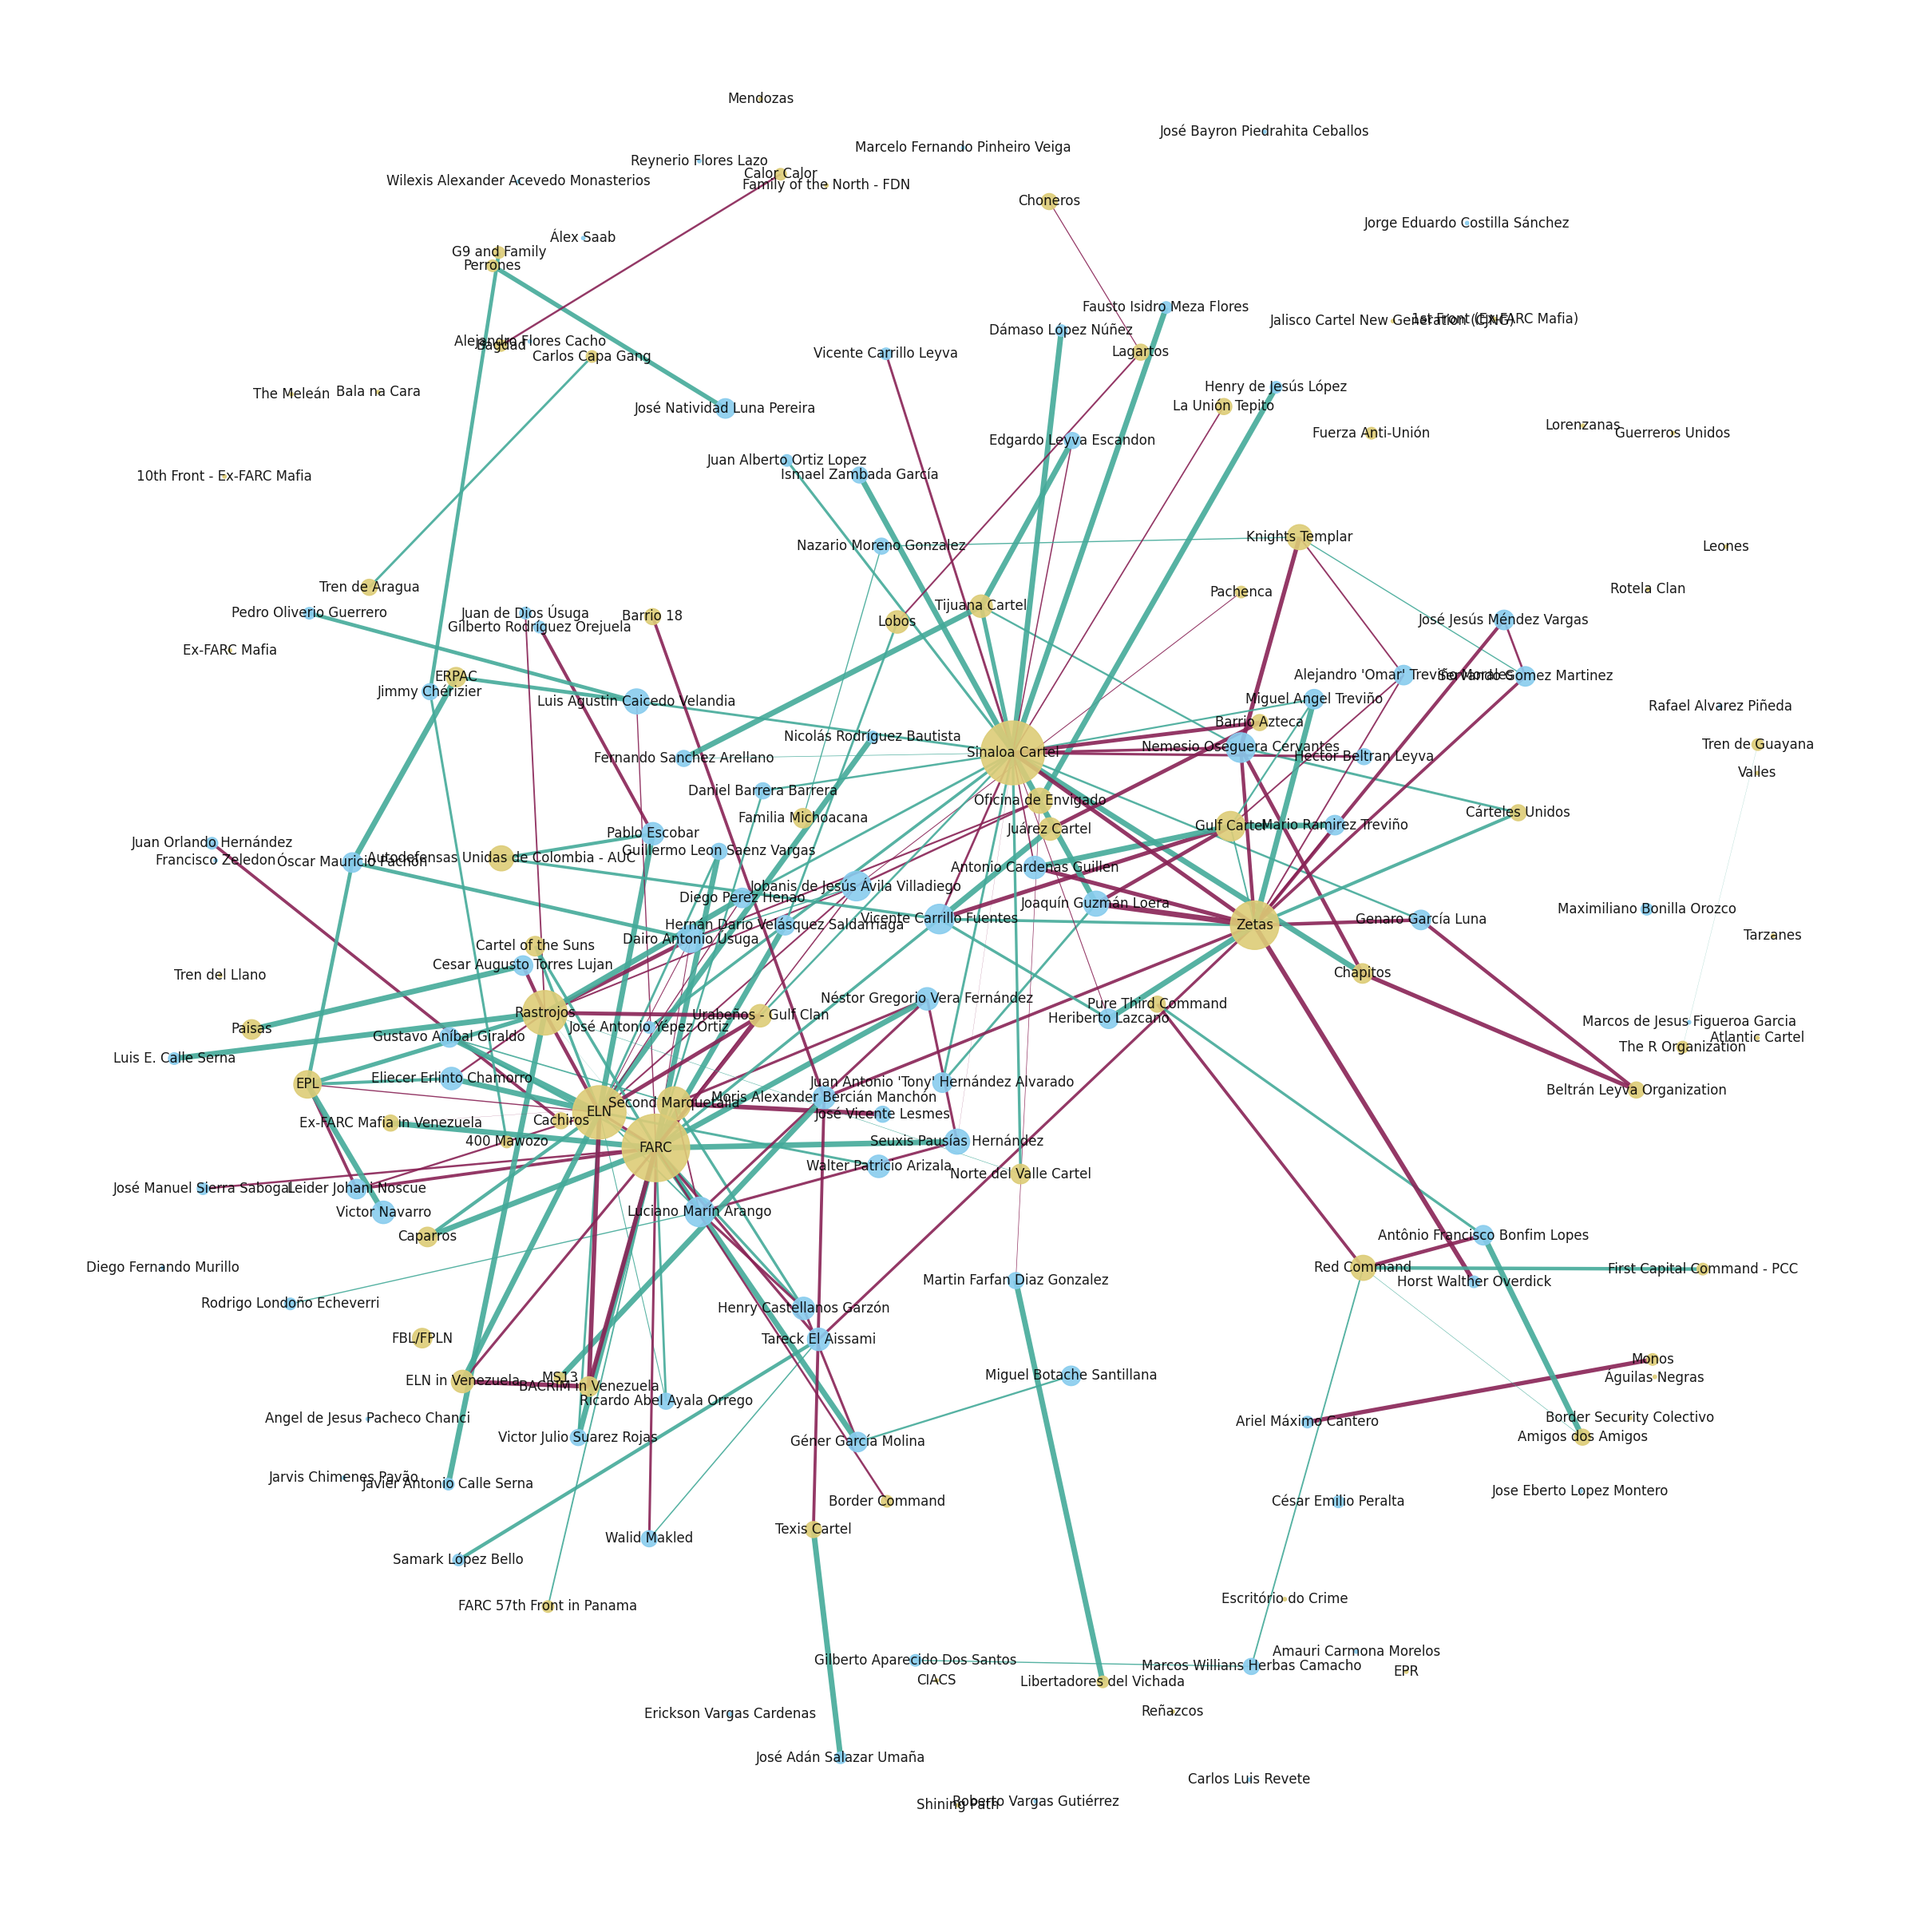

In [413]:
import math
fig = plt.figure(figsize=(24,24)) 
layout = nx.spring_layout(net_cartels, k=5/math.sqrt(net_cartels.order()))
nx.draw(net_cartels, with_labels=True, pos=layout, font_color="#000000", node_color=node_color_map, node_size=node_sizes, edge_color=edge_color_map, width=edge_sizes, alpha=0.9)
#plt.show(block=False)

In [414]:
#fig.savefig("./images/graph.png", format="PNG", bbox_inches='tight')

In [419]:
tm = nx.google_matrix(net_cartels, alpha=1, weight="value")
eigenvalues, eigenvectors = np.linalg.eig(tm.T)
eigenvector = eigenvectors[:,np.isclose(eigenvalues, 1)][:,0]

stationary = eigenvector / eigenvector.sum()
stationary = stationary.real
indexed = list(enumerate(stationary)) # attach indices to the list
top_3 = sorted(indexed, key=operator.itemgetter(1))[-3:]
indexes = list(reversed([i for i, v in top_3]))
print(indexes)
print(operator.itemgetter(*indexes)(list(net_cartels.nodes())))

[134, 103, 136]
('FARC', 'Sinaloa Cartel', 'ELN')


In [ ]:
nx.is_connected(net_cartels)

## Analyzing organizations

In [415]:
net_organizations = net_cartels.subgraph([node for node in net_cartels if net_cartels.nodes[node]["node_type"] == "organizations"])
organizations_degrees = sorted((d for n, d in net_organizations.degree()), reverse=True)

In [ ]:
plt.figure(3,figsize=(20,20)) 
layout = nx.spring_layout(net_organizations, k=1)
nx.draw(net_organizations, with_labels=True, pos=layout, node_color="red", node_size=[v * 100 for v in dict(nx.degree(net_organizations)).values()])
plt.plot()

[]

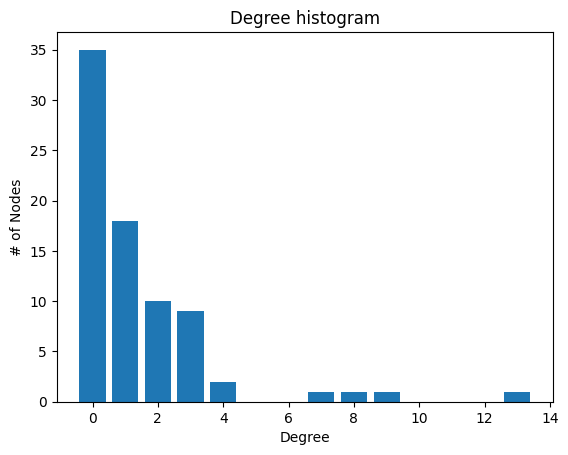

In [416]:
fig, ax = plt.subplots()
ax.bar(*np.unique(organizations_degrees, return_counts=True))
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.plot()

## Analyzing individuals

In [420]:
net_individuals = net_cartels.subgraph([node for node in net_cartels if net_cartels.nodes[node]["node_type"] == "individuals"])
individuals_degrees = sorted((d for n, d in net_individuals.degree()), reverse=True)

[]

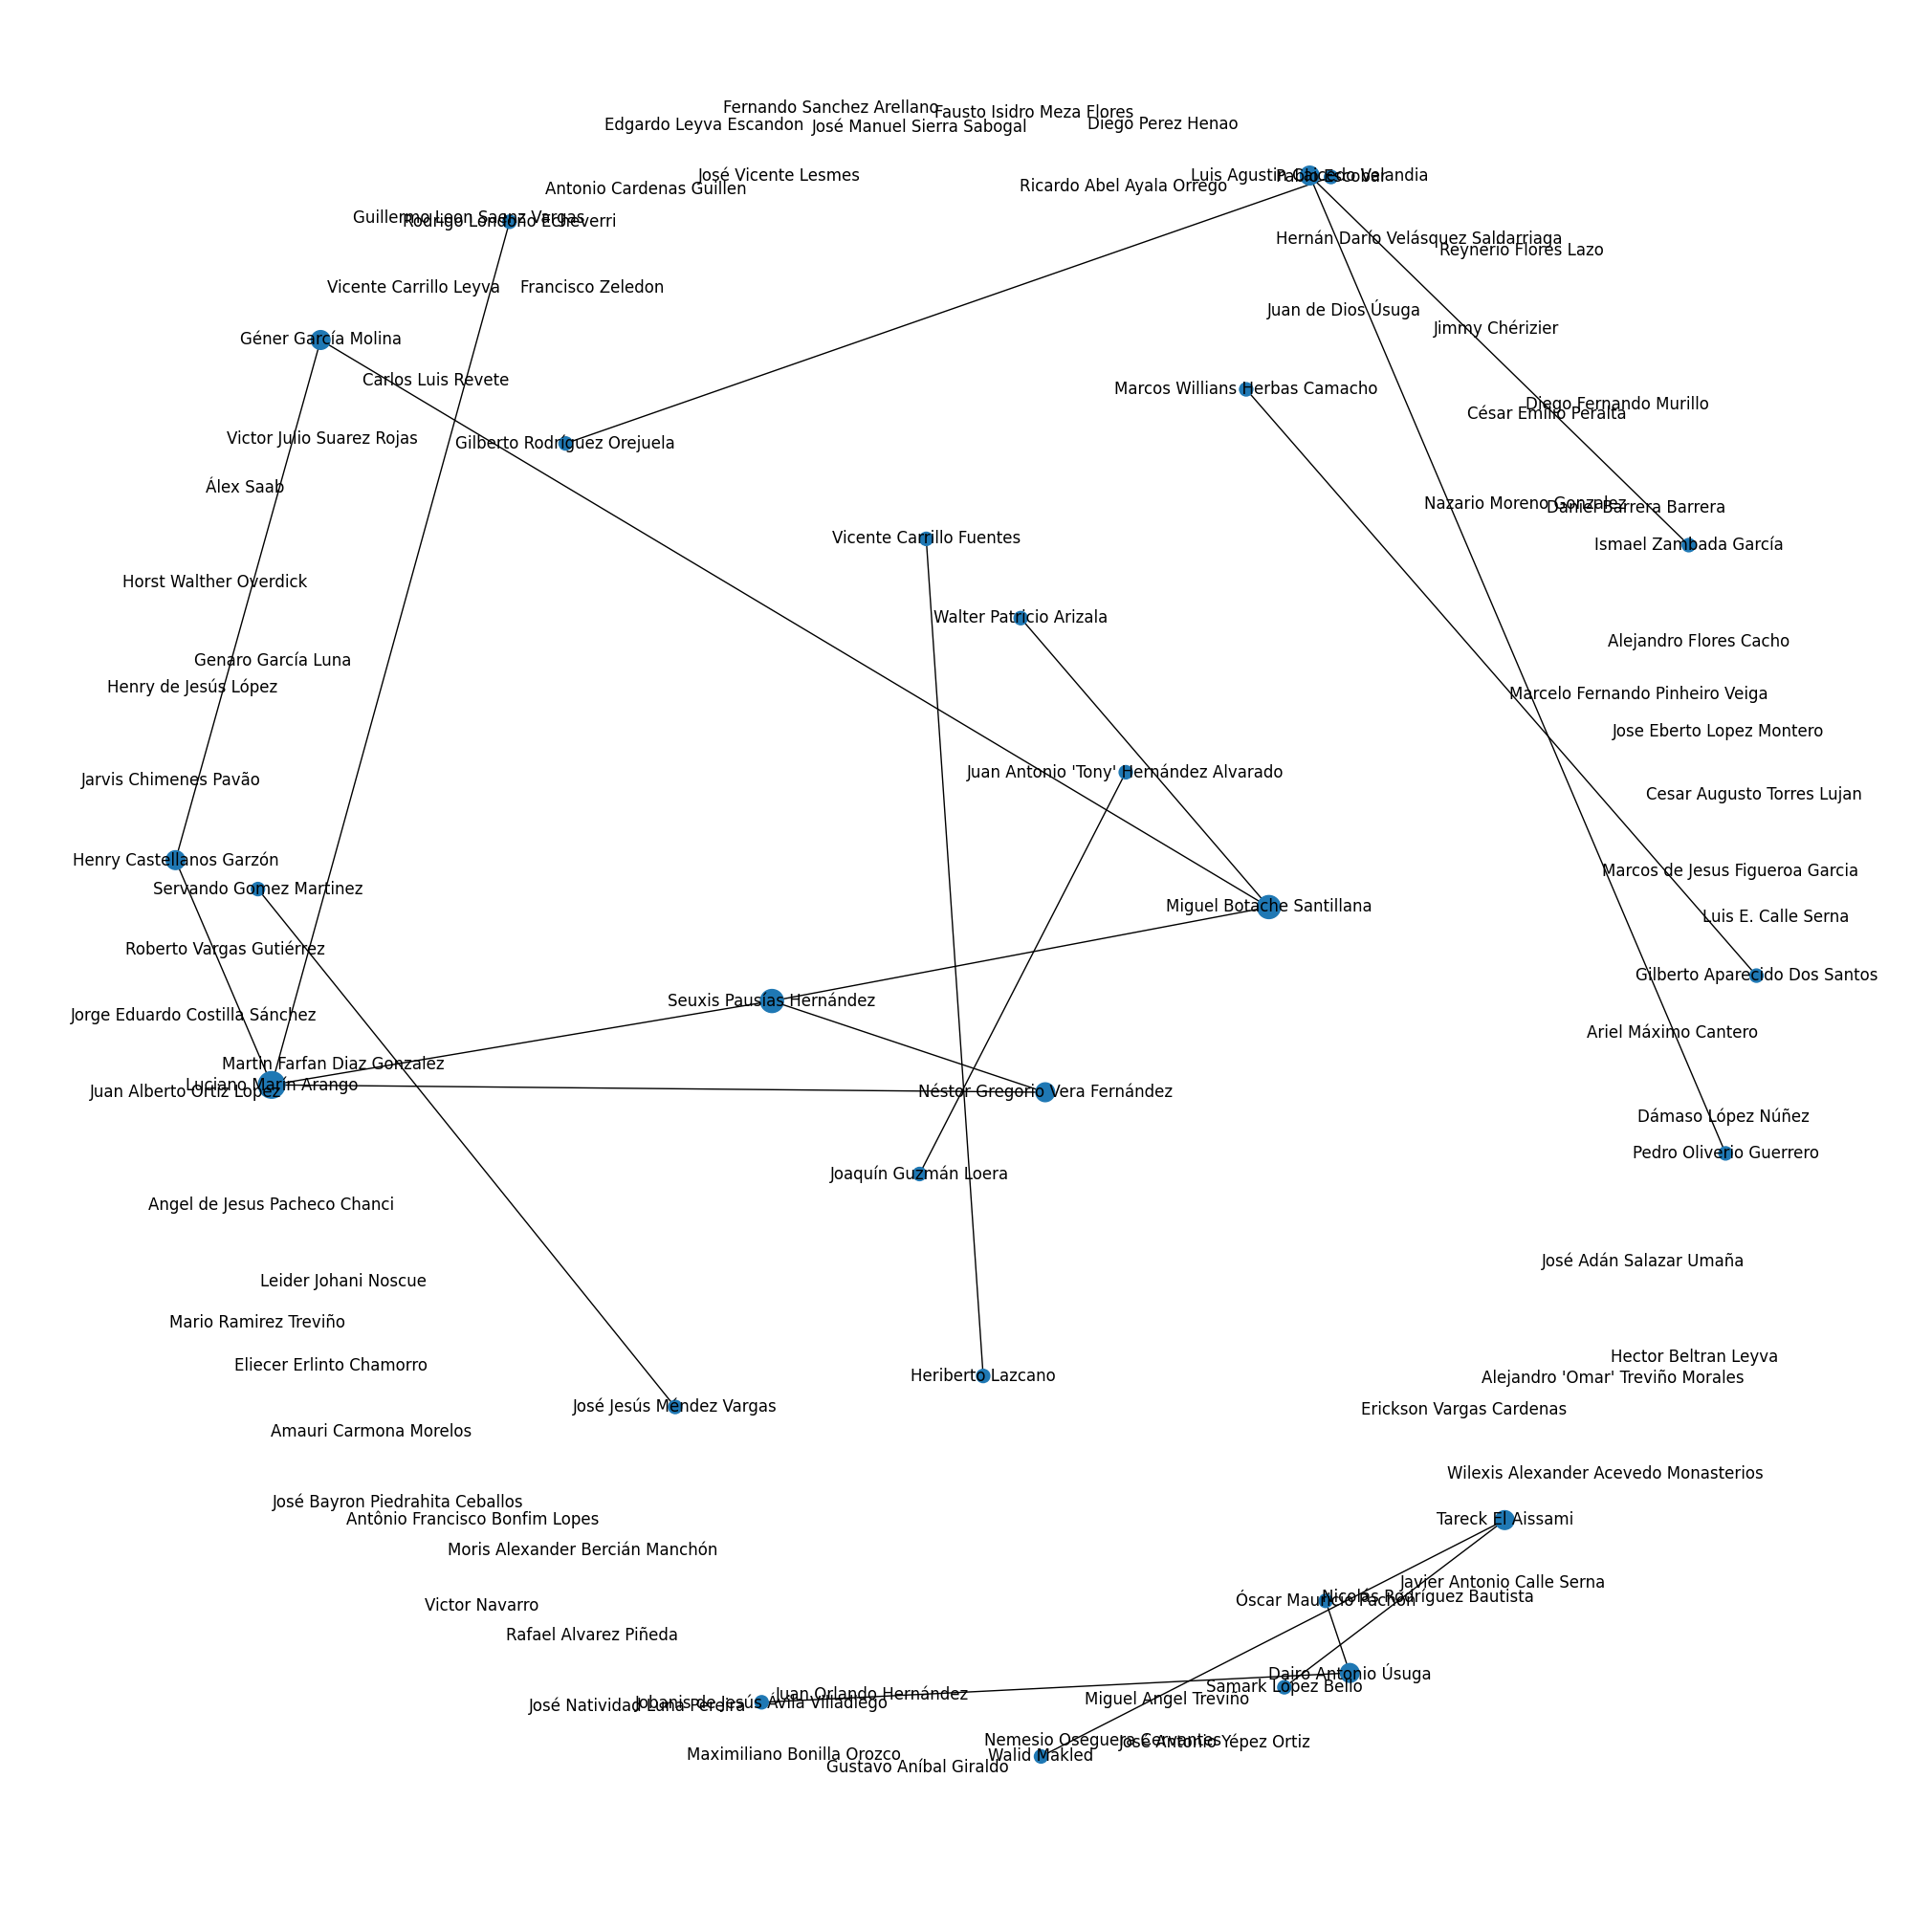

In [421]:
plt.figure(3,figsize=(20,20)) 
layout = nx.spring_layout(net_individuals, k=1)
nx.draw(net_individuals, with_labels=True, pos=layout, node_size=[v * 100 for v in dict(nx.degree(net_individuals)).values()])
plt.plot()

In [422]:
tm = nx.google_matrix(net_individuals, alpha=1, weight="value")
eigenvalues, eigenvectors = np.linalg.eig(tm.T)
eigenvector = eigenvectors[:,np.isclose(eigenvalues, 1)][:,0]

stationary = eigenvector / eigenvector.sum()
stationary = stationary.real
indexed = list(enumerate(stationary)) # attach indices to the list
top_3 = sorted(indexed, key=operator.itemgetter(1))[-3:]
indexes = list(reversed([i for i, v in top_3]))
print(indexes)
print(operator.itemgetter(*indexes)(list(net_individuals.nodes())))

[62, 14, 36]
('Dairo Antonio Úsuga', 'Luis Agustin Caicedo Velandia', 'Óscar Mauricio Pachón')


In [ ]:
degree_sequence = sorted((d for n, d in net_individuals.degree()), reverse=True)

In [ ]:
fig, ax = plt.subplots()
ax.bar(*np.unique(individuals_degrees, return_counts=True))
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
plt.plot()